In [29]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

## Load data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

n_train_sample = 4000

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Train pipeline
ds_train = ds_train.take(n_train_sample)
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Test pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

n_train = 1000
n_test = 1000

# Preprocess the data (these are NumPy arrays)
X_train = X_train.reshape(60000, 784)[:n_train, :].astype("float32") / 255
X_test = X_test.reshape(10000, 784)[:n_test, :].astype("float32") / 255

y_train = y_train[:n_train].astype("int32")
y_test = y_test[:n_test].astype("int32")

In [35]:
a = [[0,1], [1,0], [0,1]]
print(np.argmax(a, axis=1).reshape(-1, 1))

[[1]
 [0]
 [1]]


## Helper functions

In [26]:
def brute_predict(model, X):
    """ Otherwise, predict doesn't work with modified activations """
    for layer in model.layers:
        X = layer(X)
    return X.numpy()

def model2internal_rep(model, X, decision_boundary=False):
    """Note, for now this assumes binary classification due to the decision boundary"""
    internal_rep = []
    act = X
    for layer in model.layers[:-1]:
        act = layer(act)
        internal_rep.append(act != 0)
    if decision_boundary:
        act = model.layers[-1](act)
        internal_rep.append(act.numpy().argmax(axis=1).reshape(-1, 1))
        decision_rep = np.hstack(internal_rep).astype(int)
        internal_rep = np.hstack(internal_rep[:-1]).astype(int)
        return internal_rep, decision_rep
    else:
        internal_rep = np.hstack(internal_rep).astype(int)
        return internal_rep

## Train models

In [27]:
critical_n_units = int((n_train * 10 - 10) / float(28 * 28 + 10))

n_units_to_test = sorted(set(
    list(range(critical_n_units - 7, critical_n_units + 4)) +
    list(range(5, 55, 5)) + list(range(50, 105, 10)) + [120, 150, 200]
))

results_dict = {}
for n_units in tqdm(n_units_to_test):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.Sequential([
      # tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(n_units, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    
    n_epochs = 50
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[metric],
    )
    
    model_results = defaultdict(list)

    for epoch in range(n_epochs):
        history = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=1,
            validation_data=(X_test, y_test),
            verbose=(epoch%10==0),
        )
        internal_rep, decision_rep = model2internal_rep(model, X_train, decision_boundary=True)
        model_results['activated_regions_train'].append(np.unique(internal_rep, axis=0).shape[0])
        model_results['decision_regions_train'].append(np.unique(decision_rep, axis=0).shape[0])

        internal_rep, decision_rep = model2internal_rep(model, X_test, decision_boundary=True)
        model_results['activated_regions_test'].append(np.unique(internal_rep, axis=0).shape[0])
        model_results['decision_regions_test'].append(np.unique(decision_rep, axis=0).shape[0])

        test_accuracy = history.history['val_sparse_categorical_accuracy'][0]
        model_results['accuracy_test'].append(test_accuracy)
        model_results['accuracy_train'].append(history.history['sparse_categorical_accuracy'][0])
    
    results_dict[total_params] = model_results

  0%|          | 0/26 [00:00<?, ?it/s]

32/32 [==============================] - 0s 4ms/step - loss: 0.3427 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.7667 - val_sparse_categorical_accuracy: 0.7650


  4%|▍         | 1/26 [00:07<03:10,  7.64s/it]

32/32 [==============================] - 0s 3ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.7910


  8%|▊         | 2/26 [00:15<03:04,  7.68s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.2002 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.5916 - val_sparse_categorical_accuracy: 0.8110


 12%|█▏        | 3/26 [00:23<02:59,  7.79s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.6131 - val_sparse_categorical_accuracy: 0.8040


 15%|█▌        | 4/26 [00:30<02:50,  7.74s/it]

32/32 [==============================] - 0s 3ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.5597 - val_sparse_categorical_accuracy: 0.8340


 19%|█▉        | 5/26 [00:38<02:41,  7.71s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.5385 - val_sparse_categorical_accuracy: 0.8340


 23%|██▎       | 6/26 [00:46<02:36,  7.82s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.5327 - val_sparse_categorical_accuracy: 0.8310


 27%|██▋       | 7/26 [00:54<02:27,  7.79s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0740 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.4879 - val_sparse_categorical_accuracy: 0.8410


 31%|███       | 8/26 [01:02<02:20,  7.82s/it]

32/32 [==============================] - 0s 3ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8270


 35%|███▍      | 9/26 [01:10<02:13,  7.87s/it]

32/32 [==============================] - 0s 3ms/step - loss: 0.0560 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.5129 - val_sparse_categorical_accuracy: 0.8390


 38%|███▊      | 10/26 [01:17<02:04,  7.81s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0554 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.4813 - val_sparse_categorical_accuracy: 0.8360


 42%|████▏     | 11/26 [01:25<01:57,  7.80s/it]

32/32 [==============================] - 0s 3ms/step - loss: 0.0384 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4788 - val_sparse_categorical_accuracy: 0.8500


 46%|████▌     | 12/26 [01:34<01:51,  8.00s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0270 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4758 - val_sparse_categorical_accuracy: 0.8510


 50%|█████     | 13/26 [01:42<01:44,  8.04s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0219 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8710


 54%|█████▍    | 14/26 [01:50<01:37,  8.11s/it]

32/32 [==============================] - 0s 12ms/step - loss: 0.0180 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4575 - val_sparse_categorical_accuracy: 0.8590


 58%|█████▊    | 15/26 [01:59<01:30,  8.22s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0146 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5003 - val_sparse_categorical_accuracy: 0.8580


 62%|██████▏   | 16/26 [02:07<01:22,  8.26s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0148 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5436 - val_sparse_categorical_accuracy: 0.8400


 65%|██████▌   | 17/26 [02:15<01:15,  8.36s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0120 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5073 - val_sparse_categorical_accuracy: 0.8580


 69%|██████▉   | 18/26 [02:24<01:07,  8.44s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0112 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5165 - val_sparse_categorical_accuracy: 0.8530


 73%|███████▎  | 19/26 [02:33<01:00,  8.63s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0071 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4800 - val_sparse_categorical_accuracy: 0.8630


 77%|███████▋  | 20/26 [02:42<00:51,  8.61s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5048 - val_sparse_categorical_accuracy: 0.8640


 81%|████████  | 21/26 [02:50<00:42,  8.58s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0064 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5003 - val_sparse_categorical_accuracy: 0.8610


 85%|████████▍ | 22/26 [02:59<00:34,  8.74s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0054 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5027 - val_sparse_categorical_accuracy: 0.8660


 88%|████████▊ | 23/26 [03:08<00:26,  8.79s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0041 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4753 - val_sparse_categorical_accuracy: 0.8680


 92%|█████████▏| 24/26 [03:17<00:17,  8.83s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0035 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5007 - val_sparse_categorical_accuracy: 0.8690


 96%|█████████▌| 25/26 [03:27<00:09,  9.05s/it]

32/32 [==============================] - 0s 4ms/step - loss: 0.0027 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5012 - val_sparse_categorical_accuracy: 0.8710


100%|██████████| 26/26 [03:36<00:00,  8.35s/it]


In [30]:
with open('./mnist_decision_region_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

## Plot Results

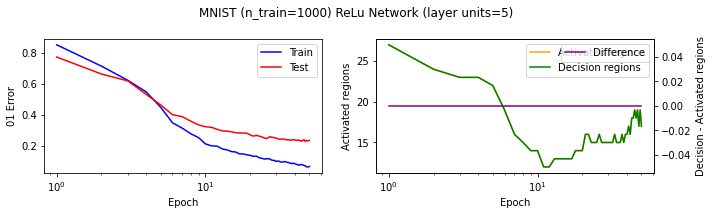

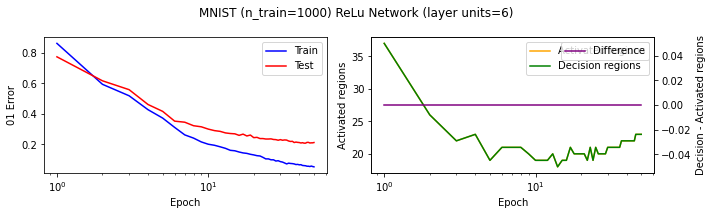

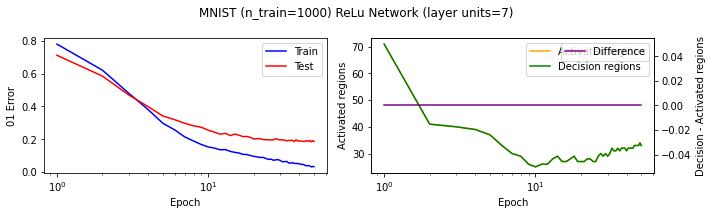

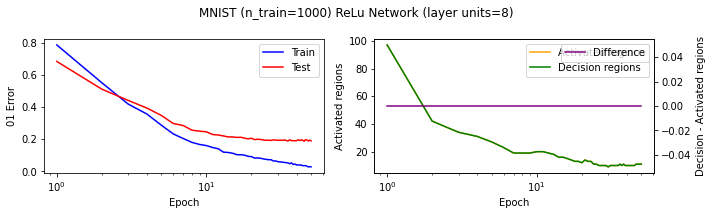

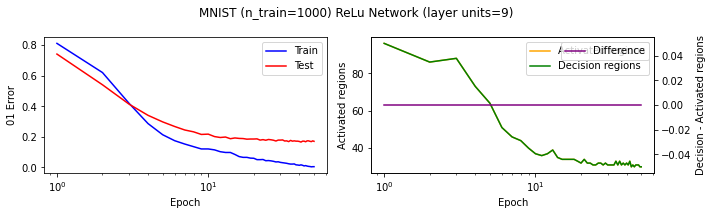

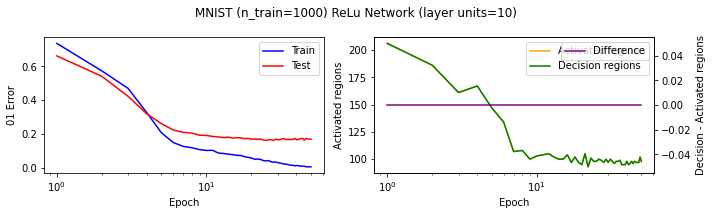

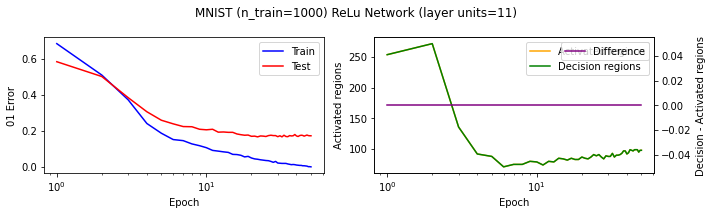

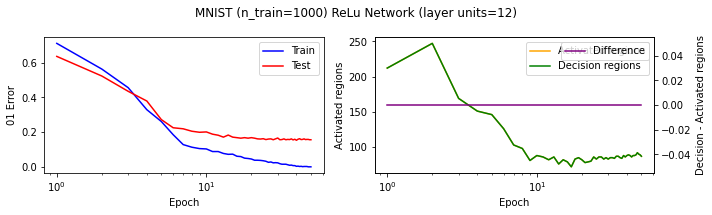

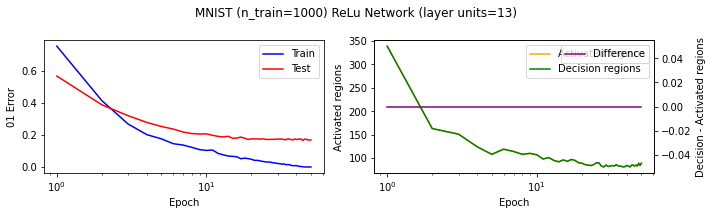

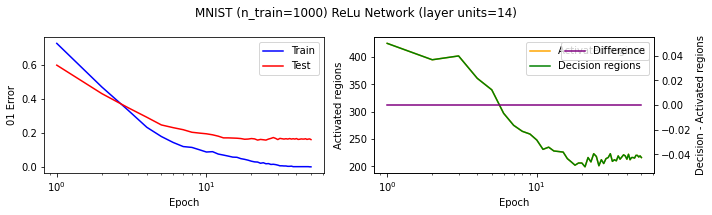

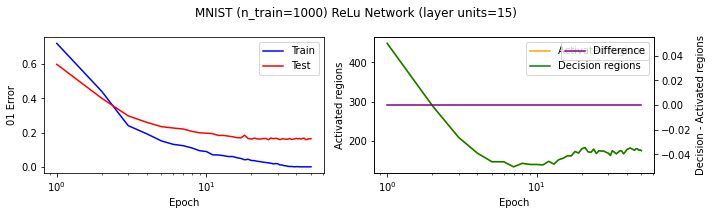

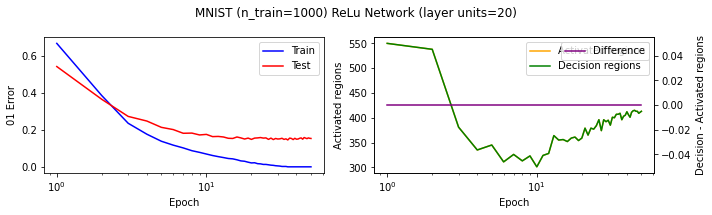

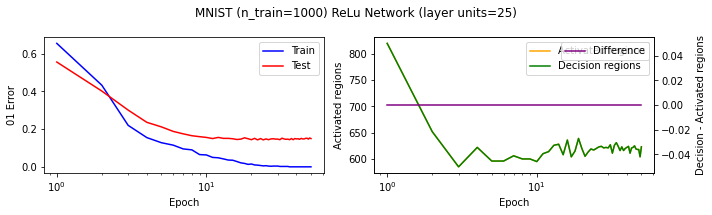

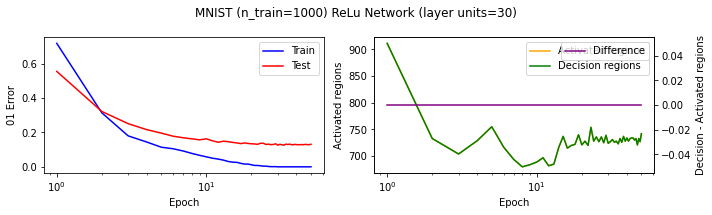

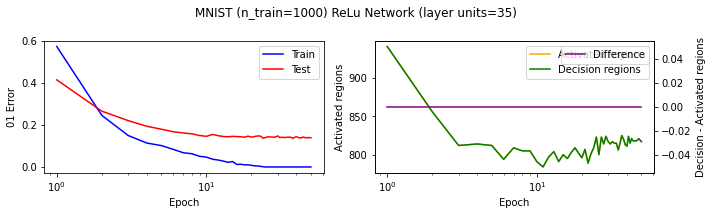

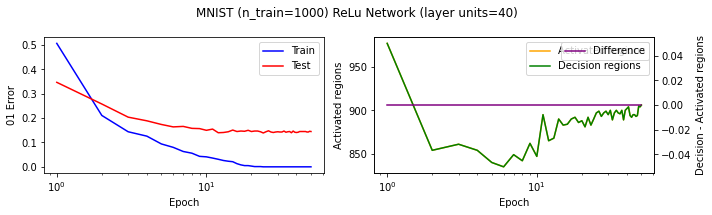

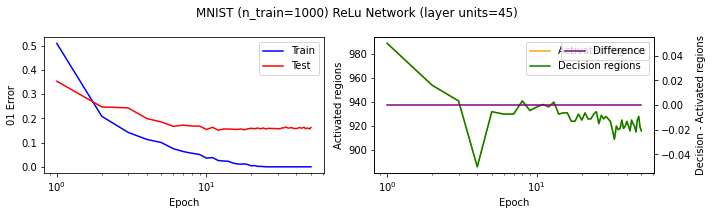

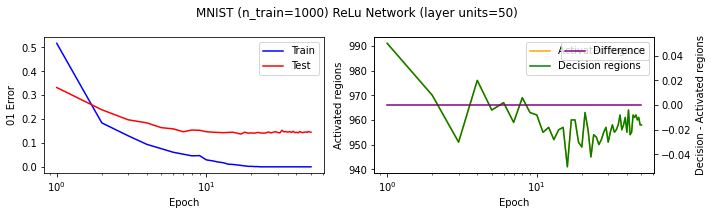

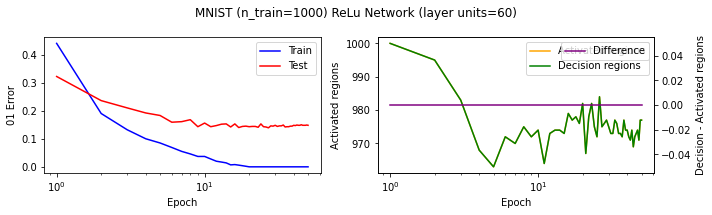

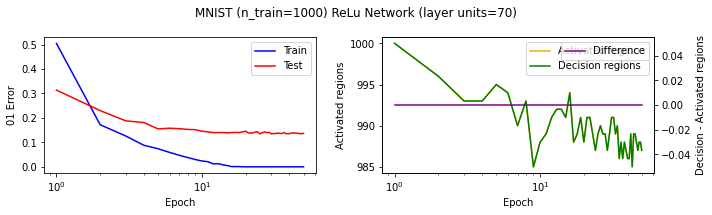

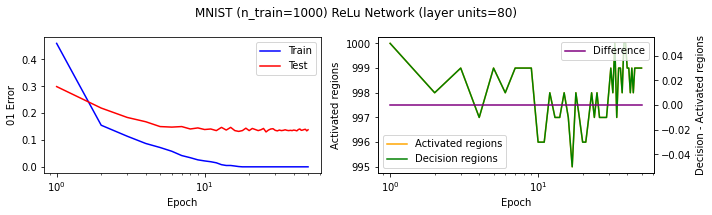

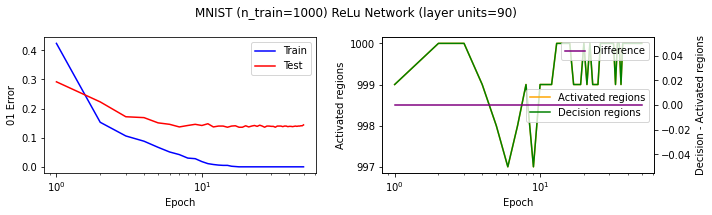

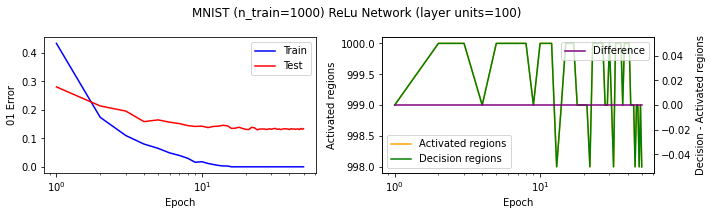

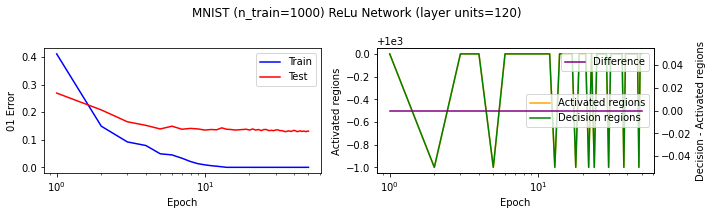

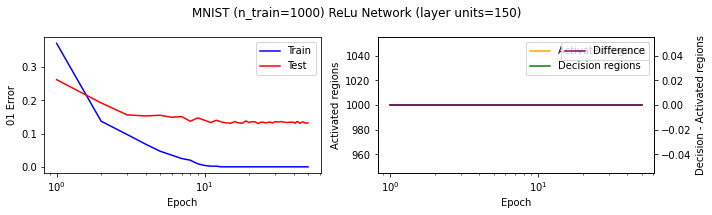

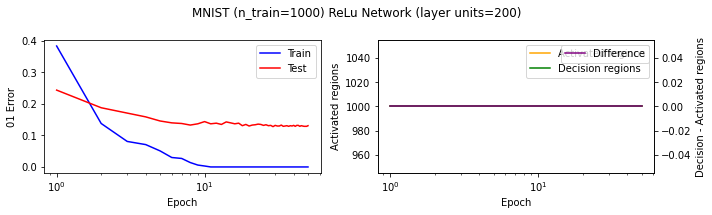

In [32]:
for idx, tp in enumerate(results_dict.keys()):
    train_error = 1 - np.asarray(results_dict[tp]['accuracy_train'])
    test_error = 1 - np.asarray(results_dict[tp]['accuracy_test'])
    n_regions = results_dict[tp]['activated_regions_train']
    n_decision_regions = results_dict[tp]['activated_regions_train']

    epochs = np.arange(len(train_error)) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(epochs, train_error, c='blue', label='Train')
    ax1.plot(epochs, test_error, c='red', label='Test')
    ax1.legend()#loc='upper right')
    ax1.set_xscale('log')
    ax1.set_ylabel('01 Error')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(epochs, n_regions, c='orange', label='Activated regions')
    ax2.plot(epochs, n_decision_regions, c='green', label='Decision regions')
    ax2.legend()#loc='upper right')
    ax2.set_xlabel('Epoch')
    ax2.set_xscale('log')
    ax2.set_ylabel('Activated regions')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, np.asarray(n_decision_regions) - np.asarray(n_regions), c='purple', label='Difference')
    ax2_twin.legend()#loc='lower left')
    ax2_twin.set_ylabel('Decision - Activated regions')

    plt.suptitle(f'MNIST (n_train={n_train}) ReLu Network (layer units={n_units_to_test[idx]})')
    plt.tight_layout()
    plt.show()